In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
train = pd.read_csv("/Users/gaozhiping/Desktop/Kaggle/House/train.csv")
test = pd.read_csv("/Users/gaozhiping/Desktop/Kaggle/House/test.csv")

In [4]:
train.head(9)
#train.columns   # Briefly check the data set

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [5]:
# As data description said, some "Na" means "None"
train["PoolQC"]      = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"]       = train["Alley"].fillna("None")
train["Fence"]       = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

# Utilities" is useless, because its values are the same
train = train.drop(["Utilities"],axis=1)

# Some columns without values are most likely meaning "None"
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


# Do the same to the test set
# As data description said, some "Na" means "None"
test["PoolQC"]      = test["PoolQC"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")
test["Alley"]       = test["Alley"].fillna("None")
test["Fence"]       = test["Fence"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")

# Utilities" is useless, because its values are the same
test = test.drop(["Utilities"],axis=1)

# Some columns without values are most likely meaning "None"
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    test[col] = test[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    test[col] = test[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    test[col] = test[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    test[col] = test[col].fillna('None')
test["MasVnrType"] = test["MasVnrType"].fillna("None")
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [6]:
# But testing set still has some missing value
miss_list = test.columns[test.isnull().any()]

# I am planing to fill them with mode value of training set
for i in miss_list:
    try:
        test[i] = test[i].fillna(train[i].mode()[0])
    except:
        test[i] = test[i].fillna(train[i].max())

In [7]:
## Missing value first
total   = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
mess_column  = missing_data.index[missing_data.Total >= 90]
train = train.drop(mess_column, axis=1)
train = train.dropna(axis=0)

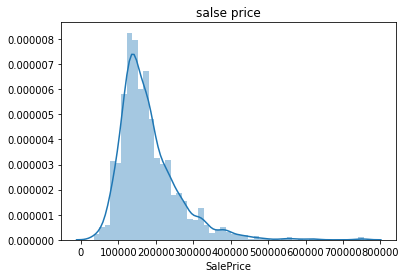

Skewness: 1.881943
Kurtosis: 6.529263


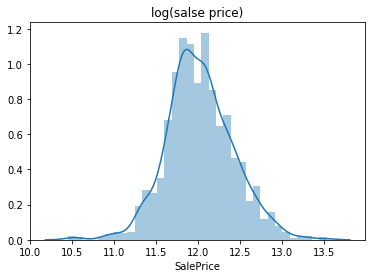

Skewness: 0.121318
Kurtosis: 0.806928


In [8]:
# Analyze the response
train['SalePrice'].describe()
# histogram
sns.distplot(train['SalePrice'])  
plt.title("salse price")
plt.show()                                           # seems a littile skewed
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

# Adding logrithm to response
train["SalePrice"] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice'])
plt.title("log(salse price)")
plt.show()                                          #seems normal
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [9]:
# Checking Missing Value
train.info()

# Get numerical data
train_numeric = train._get_numeric_data()
train_numeric.info()

# Get the rest of the data
num_list = train_numeric.columns.tolist()
rest_list = train.columns.tolist()
rest_list = [i for i in rest_list if i not in num_list]

train_rest = train[rest_list]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1459 non-null object
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            1459 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1459 non-null object
Exterior2nd      1459 non

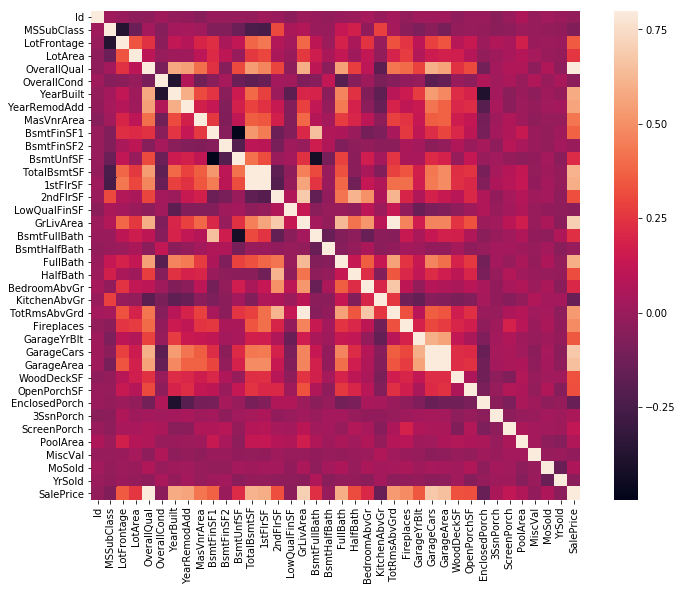

In [10]:
#let's look at the correlation between vatiables
corrmat = train_numeric.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True); 
# Seems like there is a multicollinearity problem

In [11]:
col_corr = corrmat.columns
multico = dict()
for i in col_corr:
    for j in corrmat[i][corrmat[i] > 0.8 ].index:
        if i != j and i in multico.keys():
            multico[i] = multico[i].append(j)
        else:
            if i != j and j not in multico.keys():
                multico[i] = [j]
    
    for j in corrmat[i][corrmat[i] < -0.8 ].index:
        if i != j & multico[i]:
            multico[i] = multico[i].append(j)
        else:
            if i != j :
                multico[i] = [j]



In [12]:
# featuers in this dictionary are highly correlated to each other
multico
# I am thinking about using PCA or remove some of them

{'OverallQual': ['SalePrice'],
 'TotalBsmtSF': ['1stFlrSF'],
 'GrLivArea': ['TotRmsAbvGrd'],
 'GarageCars': ['GarageArea']}

Seems like this graph is not so clear, so I tried another way. But here are some conclution.

In [13]:
train['MSSubClass'] = train['MSSubClass'].apply(str)
train['OverallCond'] = train['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

test['MSSubClass'] = test['MSSubClass'].apply(str)
test['OverallCond'] = test['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [14]:
cols = ["Street", "MSZoning", "Alley", "LotShape", "LandContour", "PoolQC", "Fence", "MasVnrType",
      "SaleType", "SaleCondition", "YrSold", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
      "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
      "SaleCondition", "SaleType", "Fence", "MiscFeature", "PoolQC", "KitchenQual", "Functional",
      "GarageType", "GarageQual", "BsmtCond","BsmtQual", "Heating", "HeatingQC", "CentralAir",
      "Electrical", "ExterCond", "ExterQual", "Foundation", "BsmtExposure", "YrSold", "MoSold",
      "MSSubClass", "OverallCond", "BsmtFinType1", "FireplaceQu", "PavedDrive", "BsmtFinType1",
       "BsmtFinType2","GarageFinish", "GarageCond"]

In [15]:
from sklearn.preprocessing import LabelEncoder
column_name = []
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values) + list(test[c].values)) 
    for i in lbl.classes_:
        name = str(c) + "_" + str(i)
        column_name.append(name)
    #print(c)
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))

In [16]:
train.shape
y = train["SalePrice"]
train = train.drop("SalePrice",axis=1)

In [17]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='error')
enc.fit(pd.concat([train[cols],test[cols]]))
train = train.reset_index()
test  = test.reset_index()
train[column_name] = pd.DataFrame(enc.transform(train[cols]).toarray(), columns = column_name)
test[column_name]  = pd.DataFrame(enc.transform(test[cols]).toarray(), columns = column_name)
#print(enc.get_feature_names())
train = train.drop(cols, axis=1)
test = test.drop(cols, axis=1)

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=4)

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=120)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)
test    =  pca.transform(test)

ValueError: operands could not be broadcast together with shapes (1459,120) (376,) 

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [43]:
compare_dic = {}
# Linear Regression
reg1 = LinearRegression()
# Lasso model
parameters = {"alpha" : [i/100 for i in range(0,80,5)]}
reg2 = linear_model.Lasso()
Lasso = GridSearchCV(reg2, parameters, cv = 5)
# Ridge Regression
parameters = {"alpha" : [i/100 for i in range(0,80,5)]}
reg3 = Ridge()
Ridge = GridSearchCV(reg3, parameters, cv = 5)
#Elastic Net
parameters = {"alpha" : [i/100 for i in range(0,80,5)], "l1_ratio":[i/100 for i in range(0,80,5)]}
reg4 = ElasticNet(random_state=0)
Ela = GridSearchCV(reg4, parameters, cv = 5)
#Desition Tree
parameters = {"max_depth" : [30,50,80,15,20,25]}
dt   = DecisionTreeRegressor()
model_dt = GridSearchCV(dt, parameters, cv = 5)
#Random Forest
parameters = {"n_estimators" : [10,50,100,300,350], "max_depth" : [30,56,70,85,10,15,60]}
rf   = RandomForestRegressor(random_state=0)
model_RF = GridSearchCV(rf, parameters, cv = 5)

model_list = [reg1, Lasso, Ridge, Ela, model_dt, model_RF]
model_name = ["Linear Regression", "Lasso Regression", "Ridge Regression", "Elastic Net", "Decision Tree", "Random Forest"]
for i in range(len(model_list)):
    model = model_list[i]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    compare_dic[model_name[i]] = mean_squared_error(y_test, pred, )
    print(metrics.mean_squared_error(y_test, pred))

234650.68970623965
0.03471964921242932
0.019712273426378796
0.021559536790239572
0.06274055755869659


KeyboardInterrupt: 

In [35]:
parameters = {"alpha" : [i/100 for i in range(0,80,5)]}
reg3 = Ridge()
Ridge = GridSearchCV(reg3, parameters, cv = 5)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(metrics.mean_squared_error(y_test, pred))

NameError: name 'model' is not defined

In [37]:
mini = 1; para = 0
param = [i/100 for i in range(0,500,3)]
for i in param:
    reg3 = Ridge(alpha=i)
    reg3.fit(X_train, y_train)
    pred = reg3.predict(X_test)
    if metrics.mean_squared_error(y_test, pred) < mini:
        mini = metrics.mean_squared_error(y_test, pred)
        para = i                        
    #print(metrics.mean_squared_error(y_test, pred))

In [39]:
from sklearn.model_selection import cross_validate
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10, random_state=7)
reg3 = Ridge(alpha = para)
cv_results = cross_validate(reg3, X_train, y_train, scoring=('r2', 'neg_mean_squared_error'), cv=kfold, return_train_score=False)
print(cv_results)

{'fit_time': array([0.01508784, 0.00823402, 0.07131386, 0.01584196, 0.01085401,
       0.00822496, 0.00854397, 0.00868416, 0.00835991, 0.00831223]), 'score_time': array([0.00190496, 0.00228786, 0.00699186, 0.00200295, 0.00181699,
       0.0022409 , 0.00235796, 0.00235319, 0.00234413, 0.00192475]), 'test_r2': array([0.90575725, 0.89779287, 0.69781847, 0.8629819 , 0.90762552,
       0.90930777, 0.91699698, 0.88858791, 0.94100163, 0.9190348 ]), 'test_neg_mean_squared_error': array([-0.01437423, -0.01819995, -0.04250123, -0.02196064, -0.01251582,
       -0.01537404, -0.01555124, -0.01670307, -0.01055046, -0.01328132])}


In [82]:
reg3.fit(train,y)
prediction = reg3.predict(test)

In [90]:
sub = pd.DataFrame()
sub['Id'] = test["Id"]
sub['SalePrice'] = np.exp(prediction)

In [100]:
sub.to_csv("/Users/gaozhiping/Desktop/Kaggle/House/prediction.csv")

In [98]:
sub = sub.set_index("Id")

1

In [89]:
np.exp(np.log(10))

10.000000000000002

In [34]:
np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(pred)))

81945.22582998543